<a href="https://colab.research.google.com/github/Suhaila-Hassan/Sentiment-Classification/blob/main/Sentiment_Classifier_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

import pickle

import warnings
warnings.filterwarnings('ignore')

# Load Dataset

In [2]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [3]:
data=pd.read_csv("dataset.csv")
data.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [5]:
# Find empty data cells
data.isna().sum()

,0
Comment,0
Emotion,0


In [6]:
data.duplicated().sum()

np.int64(0)

# Data Visualizations

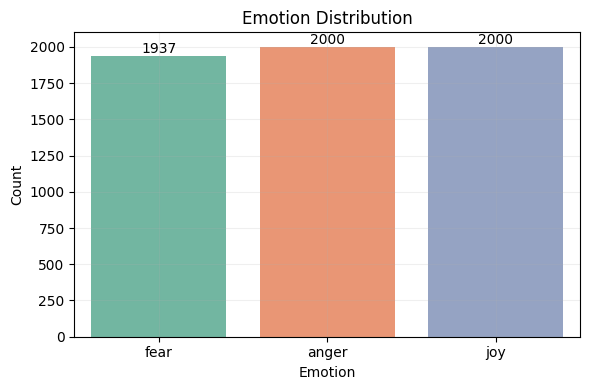

In [7]:
# Plot class distribution with count labels
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=data, x='Emotion', palette='Set2')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

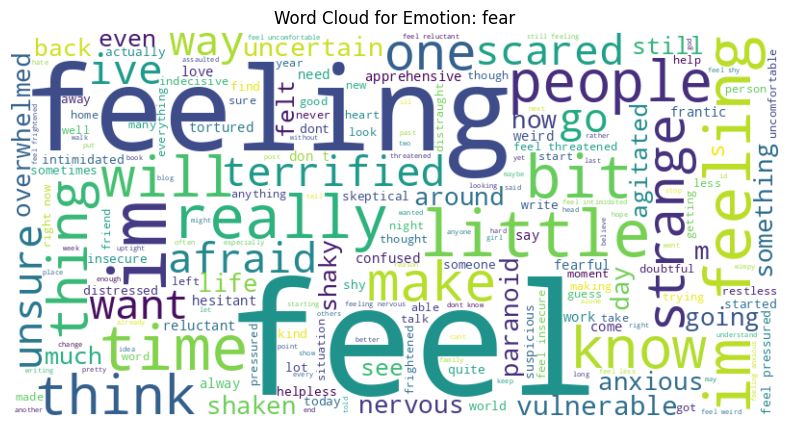

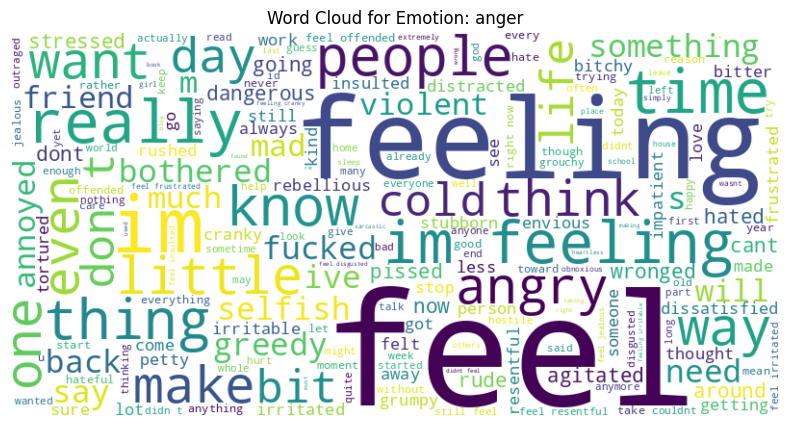

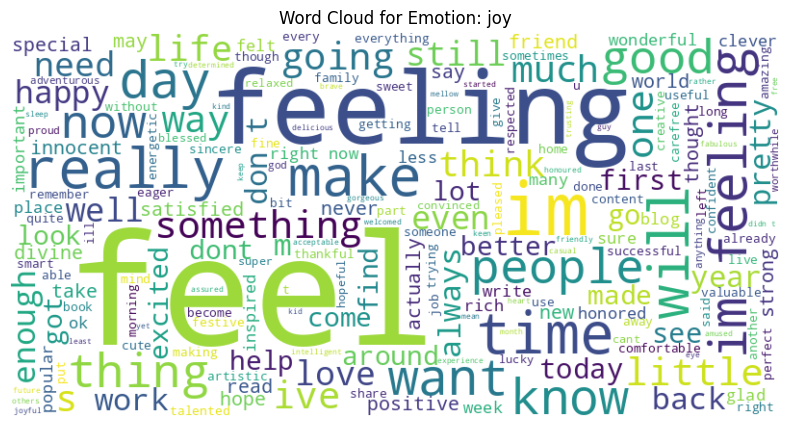

In [8]:
# WordCloud per Emotion
for emotion in data['Emotion'].unique():
    text = " ".join(data[data['Emotion'] == emotion]['Comment'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for Emotion: {emotion}")
    plt.axis("off")
    plt.show()

# Data Preprocessing

## Clean Text

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [10]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [11]:
def preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    tokens = [stemmer.stem(lemmatizer.lemmatize(t)) for t in tokens]
    return " ".join(tokens)

In [12]:
data['Cleaned'] = data['Comment'].apply(preprocess)
data.head()

,Comment,Emotion,Cleaned
0,i seriously hate one subject to death but now ...,fear,serious hate one subject death feel reluct drop
1,im so full of life i feel appalled,anger,im full life feel appal
2,i sit here to write i start to dig out my feel...,fear,sit write start dig feel think afraid accept p...
3,ive been really angry with r and i feel like a...,joy,ive realli angri r feel like idiot trust first...
4,i feel suspicious if there is no one outside l...,fear,feel suspici one outsid like raptur happen someth


## Split Dataset

In [13]:
X = data['Cleaned']
y = data['Emotion']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4749,), (1188,), (4749,), (1188,))

## Word Vectorization

### Count Vectorizer

In [15]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

### TF-IDF Vectorizer

In [16]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Evaluation

In [17]:
results = {}

def evaluate_model(name, model, X_test, y_test, y_pred):
    acc = metrics.accuracy_score(y_test, y_pred)
    results[name] = acc * 100
    print(f"\n{name} Accuracy: {acc:.2f}")
    print(metrics.classification_report(y_test, y_pred))
    plt.figure(figsize=(5,4))
    sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt='d',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test),
                cmap='coolwarm')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Model Training

In [18]:
models = {
    "LogReg_Count": LogisticRegression(random_state=0),
    "LogReg_TFIDF": LogisticRegression(random_state=0),
    "NB_Count": MultinomialNB(),
    "NB_TFIDF": MultinomialNB()
}

X_train_dict = {
    "LogReg_Count": X_train_cv,
    "LogReg_TFIDF": X_train_tfidf,
    "NB_Count": X_train_cv,
    "NB_TFIDF": X_train_tfidf
}

X_test_dict = {
    "LogReg_Count": X_test_cv,
    "LogReg_TFIDF": X_test_tfidf,
    "NB_Count": X_test_cv,
    "NB_TFIDF": X_test_tfidf
}


LogReg_Count Accuracy: 0.94
              precision    recall  f1-score   support

       anger       0.93      0.95      0.94       392
        fear       0.96      0.93      0.94       416
         joy       0.94      0.95      0.94       380

    accuracy                           0.94      1188
   macro avg       0.94      0.94      0.94      1188
weighted avg       0.94      0.94      0.94      1188



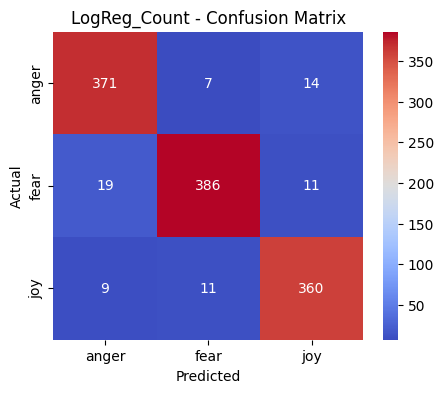


LogReg_TFIDF Accuracy: 0.93
              precision    recall  f1-score   support

       anger       0.92      0.93      0.93       392
        fear       0.94      0.90      0.92       416
         joy       0.92      0.95      0.93       380

    accuracy                           0.93      1188
   macro avg       0.93      0.93      0.93      1188
weighted avg       0.93      0.93      0.93      1188



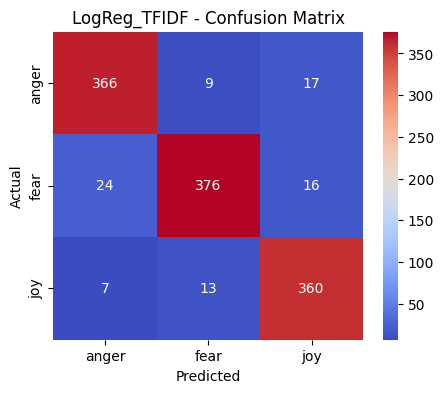


NB_Count Accuracy: 0.90
              precision    recall  f1-score   support

       anger       0.88      0.91      0.90       392
        fear       0.89      0.91      0.90       416
         joy       0.92      0.87      0.89       380

    accuracy                           0.90      1188
   macro avg       0.90      0.90      0.90      1188
weighted avg       0.90      0.90      0.90      1188



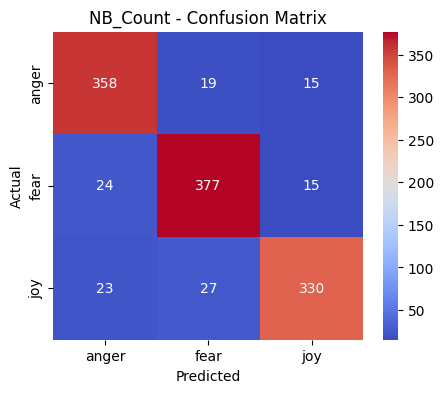


NB_TFIDF Accuracy: 0.90
              precision    recall  f1-score   support

       anger       0.88      0.92      0.90       392
        fear       0.91      0.88      0.90       416
         joy       0.91      0.90      0.91       380

    accuracy                           0.90      1188
   macro avg       0.90      0.90      0.90      1188
weighted avg       0.90      0.90      0.90      1188



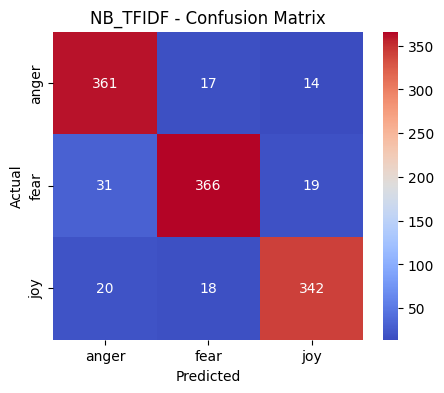

In [19]:
# Train and evaluate
for name, model in models.items():
    model.fit(X_train_dict[name], y_train)
    preds = model.predict(X_test_dict[name])
    evaluate_model(name, model, X_test_dict[name], y_test, preds)

# Model Comparison

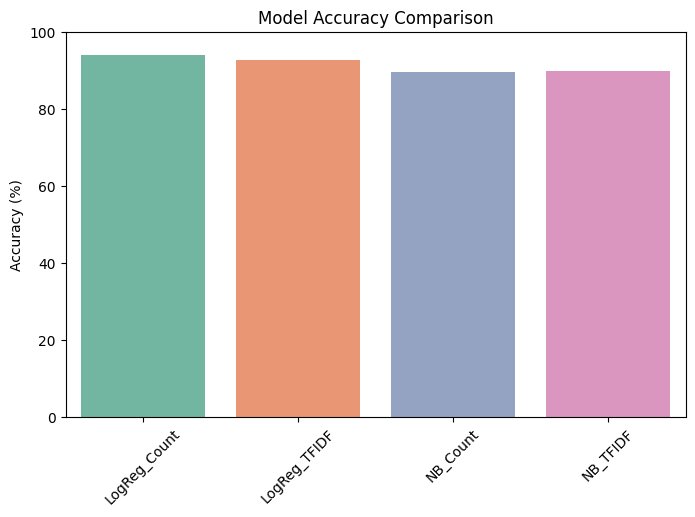

In [20]:
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='Set2')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.show()

# Save Model & Vectorizer

In [21]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
best_vectorizer = cv if "Count" in best_model_name else tfidf

print(f"Best model: {best_model_name} with accuracy: {results[best_model_name]:.2f}%")

with open("model.pkl", "wb") as f:
    pickle.dump(best_model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(best_vectorizer, f)

Best model: LogReg_Count with accuracy: 94.02%
